# Anomaly Detector (REST API)

This Jupyter notebook can be used to detect anomalies with the Microsoft Cognitive Service - Anomaly Detector. This is a RESTful web service that can be used easily embed anomaly detection capabilities into your apps so your users can quickly identify problems to minimize loss and customer impact.

The service requires no extensive knowledge about machine learning techniques. The user can simply use the API to ingest time-series data of all types and volumes and make use of the pre-trained AI models that are included in the service. The service selects the best-fitting anomaly detection model for your data to ensure high accuracy, and automatically surfaces incidents as soon as they happen.

Use Anomaly Detector to identify business incidents, monitor IoT device traffic, manage fraud, respond to changing markets, and more.

# 1. Imports & parameters

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import time
import datetime
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.plotting.register_matplotlib_converters()

In [2]:
BATCH_DETECTION_URL = "/anomalydetector/v1.0/timeseries/entire/detect"
LATEST_POINT_DETECTION_URL = "/anomalydetector/v1.0/timeseries/last/detect"

ENDPOINT = "<your-endpoint>" # e.g. Azure: "https://westus2.api.cognitive.microsoft.com" or local Docker Container: "http://localhost:5000"
SUBSCRIPTION_KEY = "<your-subscription-key>"
USE_POWER_BI = True
POWER_BI_REST_API_URL = "<your-rest-api-url>"

TIMESTAMP_COL_NAME = "timestamp"
VALUE_COL_NAME = "value"
DATETIME_FORMAT = "%Y-%m-%dT%H:%M:%SZ"

# 2. Load data

In [3]:
def read_csv(file_path, timestamp_col_name=TIMESTAMP_COL_NAME):
    df = pd.read_csv(file_path)
    df[timestamp_col_name] = pd.to_datetime(df[timestamp_col_name], format=DATETIME_FORMAT)
    return df

def read_json(file_path):
    file_handler = open(file_path)
    return json.load(file_handler)

def default(o):
    if isinstance(o, (datetime.date, datetime.datetime)):
        return o.isoformat() + "Z"

# 3. Create a function to send requests

In [4]:
def send_request(endpoint, url, subscription_key, request_data):
    headers = {"Content-Type": "application/json", "Ocp-Apim-Subscription-Key": subscription_key}
    response = requests.post(endpoint + url, headers=headers, data=request_data)
    if response.status_code == 200:
        return json.loads(response.content.decode("utf-8"))
    else:
        print("Error Code: {} \nError: {}".format(response.status_code, response.text))
        raise Exception(response.text)

# 4. Batch anomaly detection 

In [5]:
def detect_batch(request_data_df, endpoint=ENDPOINT, url=BATCH_DETECTION_URL, subscription_key=SUBSCRIPTION_KEY, sensitivity=95, granularity="daily", period=None):
    request_data_json = convert_to_json(request_data_df, sensitivity, granularity, period)
    #print("Detecting anomalies as a batch")
    result = send_request(endpoint, url, subscription_key, request_data_json)
    
    if result.get("code") != None:
        print("Detection failed. ErrorCode: {}, ErrorMessage:{}".format(result["code"], result["message"]))
    else:
        # parse the result
        columns = {"expectedValues": result["expectedValues"],
                   "isAnomaly": result["isAnomaly"],
                   "isNegativeAnomaly": result["isNegativeAnomaly"],
                   "isPositiveAnomaly": result["isPositiveAnomaly"],
                   "upperMargins": result["upperMargins"],
                   "lowerMargins": result["lowerMargins"]
                  }
        
        # create a DataFrame from the result
        result_df = pd.DataFrame(data=columns)
        result_df = pd.concat([request_data_df, result_df], axis=1, join_axes=[request_data_df.index])
        
        # plot results
        plot_results(result_df, "Batch Anomaly Detection ({} Sensitivity)".format(sensitivity))

def convert_to_json(df, sensitivity=95, granularity="daily", period=None, maxAnomalyRatio=None):
    # convert DataFrame to JSON
    json_timeseries = json.loads(df.to_json(orient="records", date_format="iso"))
    
    # construct final JSON
    json_data = {}
    json_data["granularity"] = granularity
    json_data["series"] = json_timeseries
    json_data["sensitivity"] = sensitivity
    if period is not None:
        json_data["period"] = period
    if maxAnomalyRatio is not None:
        json_data["maxAnomalyRatio"] = maxAnomalyRatio
    return json.dumps(json_data, indent=2, default=default)

def plot_results(df, title, timestamp_col_name=TIMESTAMP_COL_NAME, val_col_name=VALUE_COL_NAME):
    # prepare data
    time = df[timestamp_col_name].dt.to_pydatetime()
    upper_margin = df["expectedValues"] + df["upperMargins"]
    lower_margin = df["expectedValues"] - df["lowerMargins"]
    anomalies = df.loc[df["isAnomaly"] == True]
    
    # prepare plot
    plt.figure(figsize=(15, 10))
    plt.title(title)
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    
    # plot data
    #plt.plot_date(time, df["value"], fmt="b.", alpha=1)
    plt.plot_date(time, df["value"], fmt="b-", alpha=0.7, label="Observed Values")
    plt.plot_date(time, df["expectedValues"], fmt="g-", alpha=0.5, label="Expected Values")
    plt.plot_date(time, upper_margin, fmt="g-", alpha=0.1)
    plt.plot_date(time, lower_margin, fmt="g-", alpha=0.1)
    plt.fill_between(time, upper_margin, lower_margin, color="g", alpha=0.1, label="Boundary")
    plt.plot_date(anomalies[timestamp_col_name], anomalies[val_col_name], fmt="ro", alpha=0.7, label="Anomalies")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    # show plot
    plt.show()

# 5. Latest point anomaly detection

In [6]:
def detect_latest(request_data_df, endpoint=ENDPOINT, url=LATEST_POINT_DETECTION_URL, subscription_key=SUBSCRIPTION_KEY, sensitivity=95, granularity="daily", period=None, maxAnomalyRatio=0.25, timestamp_col_name=TIMESTAMP_COL_NAME, input_is_json=False):
    request_data_json = request_data_json = convert_to_json(request_data_df, sensitivity, granularity, period, maxAnomalyRatio)
    result = send_request(endpoint, url, subscription_key, request_data_json)
    return result

def stream_data(request_data_df, window_size, sensitivity=95, granularity="daily", period=None, maxAnomalyRatio=0.25, timestamp_col_name=TIMESTAMP_COL_NAME, val_col_name=VALUE_COL_NAME):
    num_points = len(request_data_df)
    result_df = {"expectedValues": [None]*num_points,
                 "upperMargins": [None]*num_points,
                 "lowerMargins": [None]*num_points,
                 "isNegativeAnomaly": [False]*num_points,
                 "isPositiveAnomaly":[False]*num_points,
                 "isAnomaly": [False]*num_points
                }
    
    for i in range(window_size, num_points+1):
        # define index
        start_idx = max(0, i - window_size)
        end_idx = i
        
        # send value and receive result
        single_point = detect_latest(request_data_df.iloc[start_idx:end_idx], sensitivity=sensitivity, granularity=granularity, period=period, maxAnomalyRatio=maxAnomalyRatio)
        single_point[timestamp_col_name] = request_data_df.iloc[end_idx-1][timestamp_col_name]
        single_point[val_col_name] = request_data_df.iloc[end_idx-1][val_col_name]
        
        # send data to power bi
        if USE_POWER_BI:
            send_to_power_bi(single_point)
        
        # save vlaues from rest call
        result_df["expectedValues"][i-1] = single_point["expectedValue"]
        result_df["upperMargins"][i-1] = single_point["upperMargin"]
        result_df["lowerMargins"][i-1] = single_point["lowerMargin"]
        result_df["isNegativeAnomaly"][i-1] = single_point["isNegativeAnomaly"]
        result_df["isPositiveAnomaly"][i-1] = single_point["isPositiveAnomaly"]
        result_df["isAnomaly"][i-1] = single_point["isAnomaly"]
        
        # sleep
        time.sleep(1)
    
    # create a DataFrame from the result
    result_df = pd.DataFrame(data=result_df)
    result_df = pd.concat([request_data_df, result_df], axis=1, join_axes=[request_data_df.index])
    result_df[timestamp_col_name] = pd.to_datetime(result_df[timestamp_col_name], format=DATETIME_FORMAT)
    
    # plot data
    plot_results(result_df, "Latest Point Anomaly Detection ({} Sensitivity)".format(sensitivity))

def send_to_power_bi(json_data, power_bi_rest_api_url=POWER_BI_REST_API_URL):
    data = '[{{ "expectedValue": "{0:0.1f}", "isAnomaly": "{1}", "isNegativeAnomaly": "{2}", "isPositiveAnomaly": "{3}", "lowerMargin": "{4:0.1f}", "period": "{5:0.1f}", "suggestedWindow": "{6:0.1f}", "upperMargin": "{7:0.1f}", "timestamp": "{8}", "value": "{9:0.1f}" }}]'.format(json_data["expectedValue"], json_data["isAnomaly"], json_data["isNegativeAnomaly"], json_data["isPositiveAnomaly"], json_data["lowerMargin"], json_data["period"], json_data["suggestedWindow"], json_data["upperMargin"], json_data["timestamp"], json_data["value"])
    headers = {"Content-Type": "application/json"}
    response = requests.post(power_bi_rest_api_url, data, headers=headers)
    if response.status_code == 200:
        pass
    else:
        print("Error Code: {} \nError: {}".format(response.status_code, response.text))
        raise Exception(response.text)

# 6. Apply to data

## 6.1 Batch

### 6.1.1 Daily data sample

In [7]:
df_daily = read_csv("../example-data/sample_daily.csv")

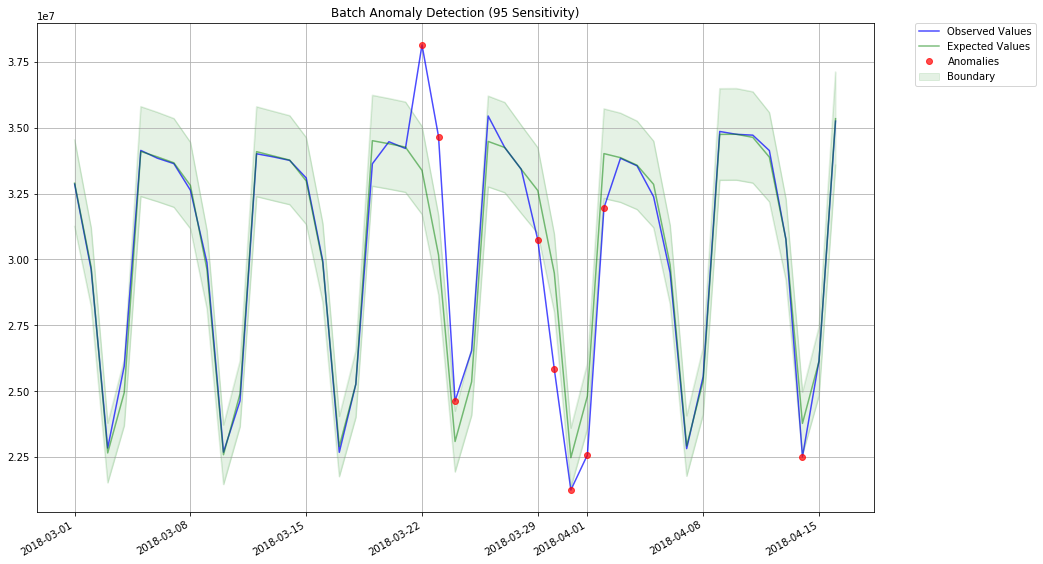

In [8]:
detect_batch(df_daily, sensitivity=95)

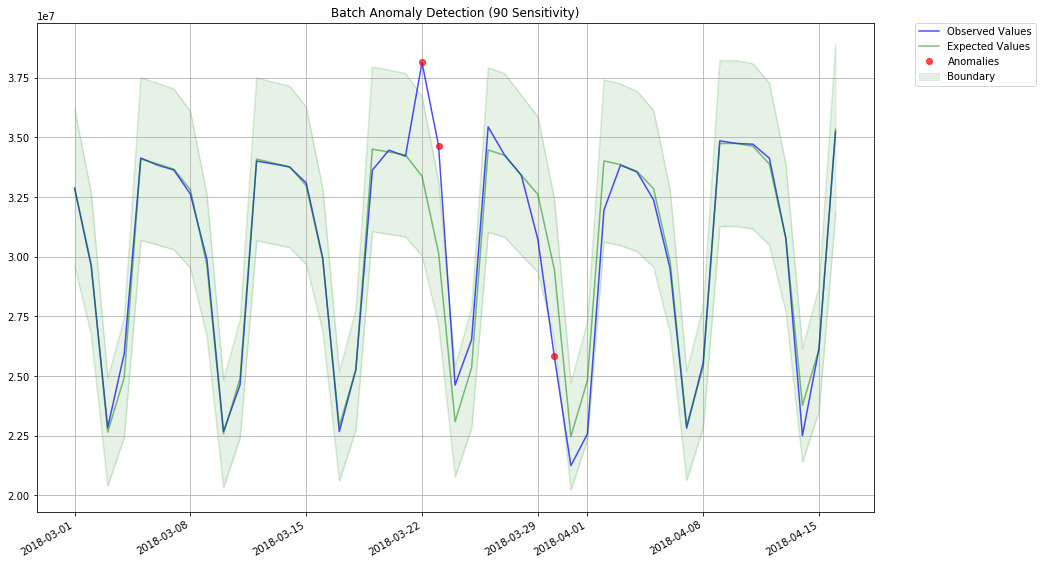

In [9]:
detect_batch(df_daily, sensitivity=90)

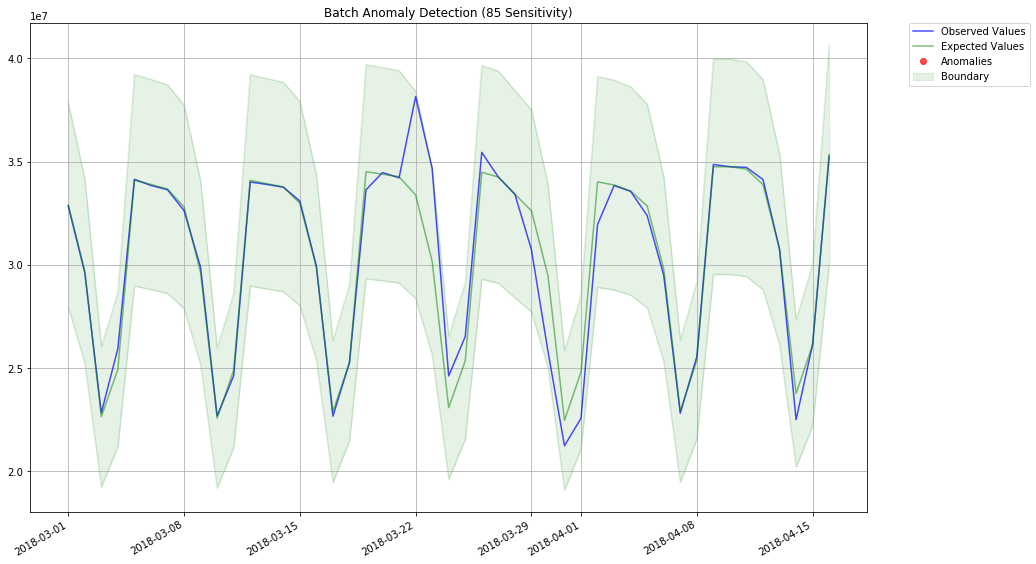

In [10]:
detect_batch(df_daily, sensitivity=85)

### 6.1.2 Hourly data sample

In [11]:
df_hourly = read_csv("../example-data/sample_hourly.csv")

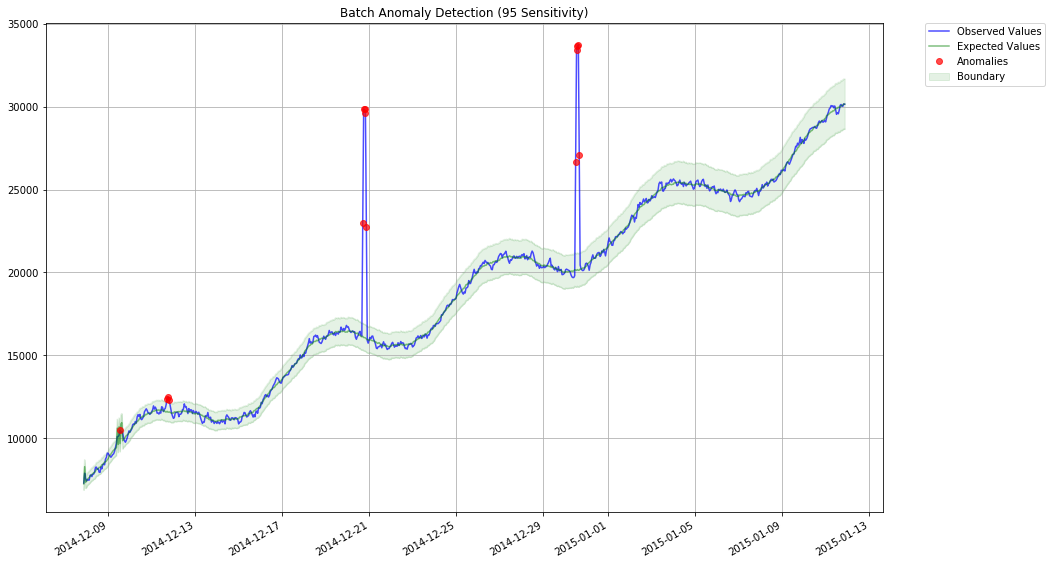

In [12]:
detect_batch(df_hourly, sensitivity=95, granularity="hourly", period=24)

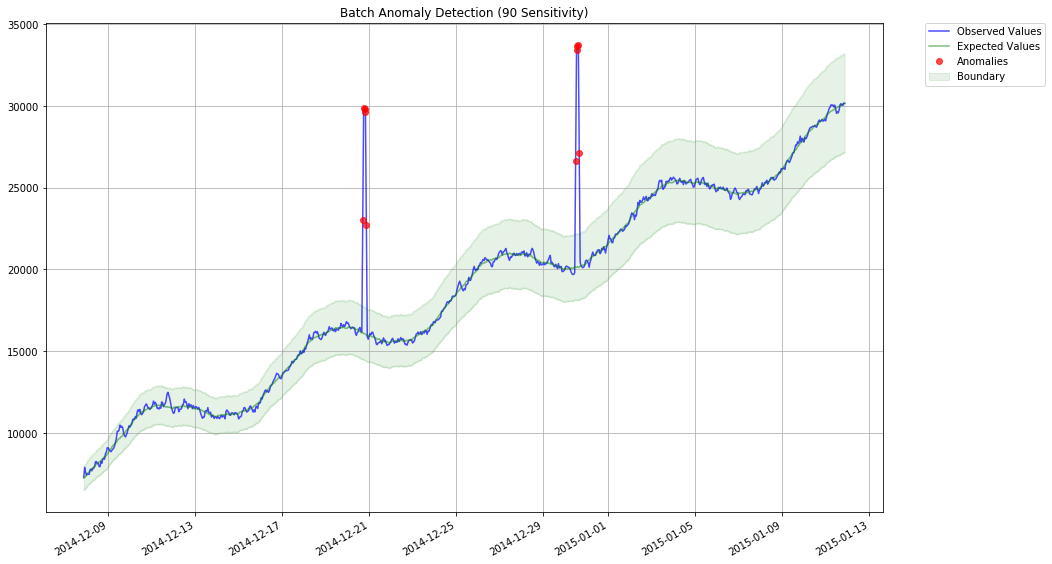

In [13]:
detect_batch(df_hourly, sensitivity=90, granularity="hourly", period=24)

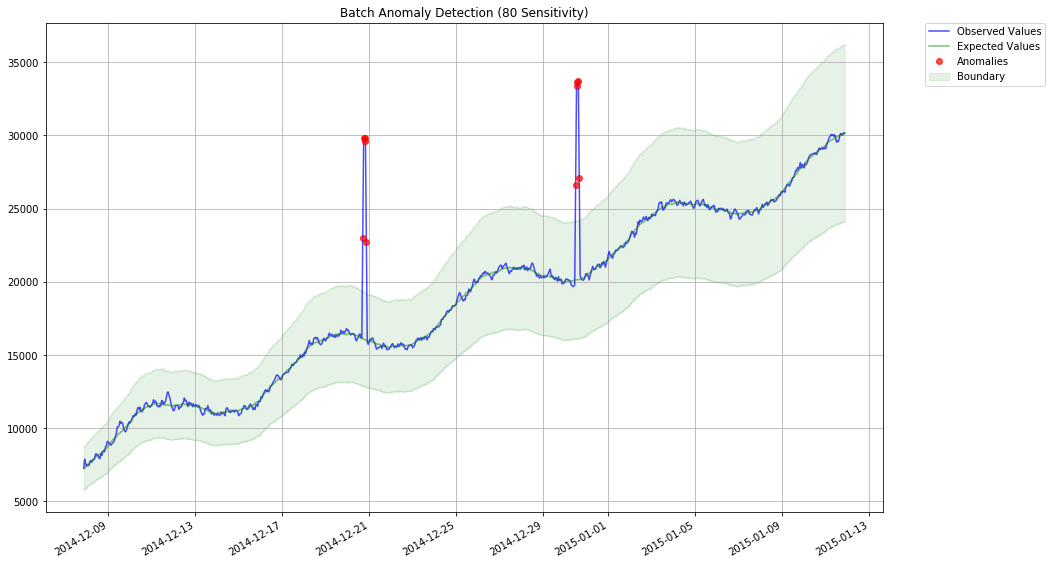

In [14]:
detect_batch(df_hourly, sensitivity=80, granularity="hourly", period=24)

## 6.2 Latest point

### 6.2.1 Daily data sample

In [15]:
df_daily = read_csv("../example-data/sample_daily.csv")

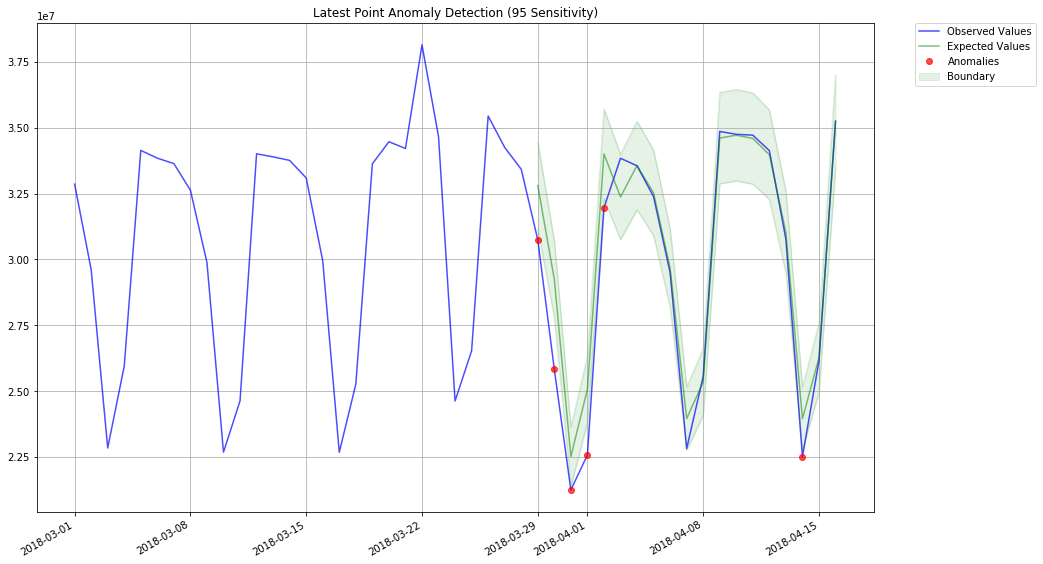

In [16]:
stream_data(df_daily, 29, sensitivity=95)

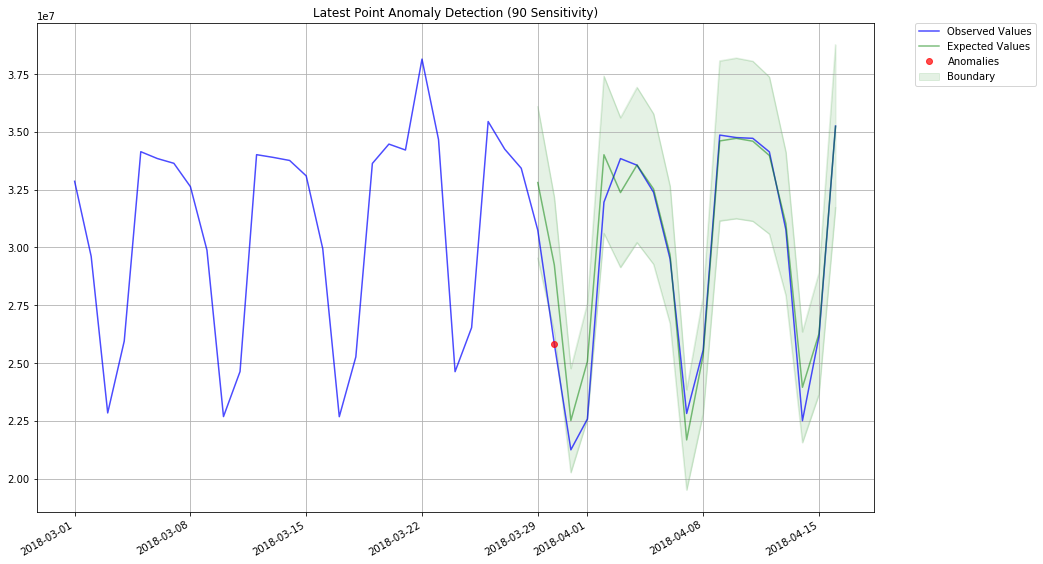

In [17]:
stream_data(df_daily, 29, sensitivity=90)

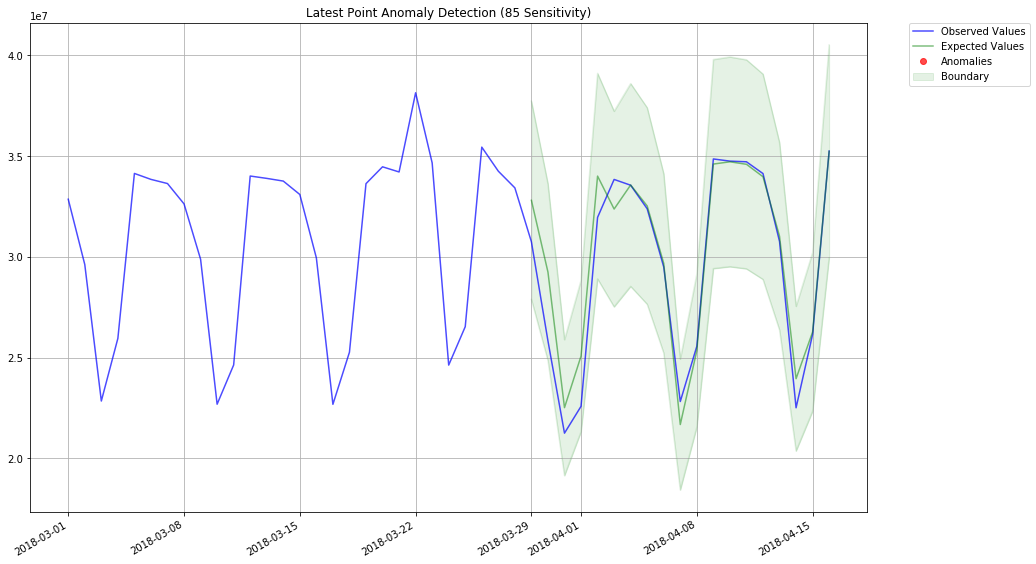

In [18]:
stream_data(df_daily, 29, sensitivity=85)

### 6.2.2 Hourly data sample

In [ ]:
df_hourly = read_csv("data/sample_hourly.csv")

In [ ]:
stream_data(df_hourly, 50, sensitivity=95, granularity="hourly")

In [ ]:
stream_data(df_hourly, 50, sensitivity=90, granularity="hourly")

In [ ]:
stream_data(df_hourly, 50, sensitivity=80, granularity="hourly")